In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras 
import keras.backend as K
from tensorflow.keras.callbacks import  EarlyStopping
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.layers import Flatten, concatenate
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape
from keras.utils.vis_utils import plot_model
import re

2024-04-26 14:32:00.960647: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 14:32:03.663884: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [53]:
hidden_dim = 2
batch_size = 100
num_classes = 10 

In [54]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [55]:
def dropout_and_batchnorm(x):
    return Dropout(0.3)(BatchNormalization()(x))

def noiser(args):
    global mean, log_var
    mean, log_var = args
    N = K.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
    return K.exp(log_var / 2) * N + mean

In [115]:
# Encoder

input_image = Input(batch_shape=(batch_size, 28, 28, 1))
fl = Flatten()(input_image)
lb = Input(shape=(num_classes,))
x = concatenate([fl, lb])
x = Dense(256, activation="relu")(x)
x = dropout_and_batchnorm(x)
x = Dense(128, activation="relu")(x)
x = dropout_and_batchnorm(x)

In [116]:
# Latent Space
mean = Dense(hidden_dim)(x)
log_var = Dense(hidden_dim)(x)
h = Lambda(noiser, output_shape=(hidden_dim,), name="latent_space")([mean, log_var])

In [117]:
# Decoder
input_decoder = Input(shape=(hidden_dim,))
lb_decoder = Input(shape=(num_classes,))
d = concatenate([input_decoder,lb_decoder])
d = Dense(128, activation="relu")(d)
d = dropout_and_batchnorm(d)
d = Dense(256, activation="relu")(d)
d = dropout_and_batchnorm(d)
d = Dense(28*28, activation="sigmoid")(d)
decoded = Reshape((28, 28, 1))(d)

In [118]:
def vae_loss(x, y):
    x = K.reshape(x, shape=(batch_size, 28*28))
    y = K.reshape(y, shape=(batch_size, 28*28))
    loss = K.sum(K.square(x-y), axis=-1)
    kl_loss = -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis=-1)
    return loss + kl_loss

In [119]:
encoder = keras.Model([input_image, lb], h, name="encoder")
decoder = keras.Model([input_decoder, lb_decoder], decoded, name="decoder")

cvae = keras.Model(inputs = [input_image, lb, lb_decoder], 
                   outputs = decoder([encoder([input_image,lb]), lb_decoder]),
                   name="cvae")

cvae.compile(optimizer="adam", loss=vae_loss)

plot_model(encoder, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)
plot_model(decoder, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

cvae.summary()

Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_49 (InputLayer)          [(100, 28, 28, 1)]   0           []                               
                                                                                                  
 input_50 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 encoder (Functional)           (100, 2)             238468      ['input_49[0][0]',               
                                                                  'input_50[0][0]']               
                                                                                                  
 input_52 (InputLayer)          [(None, 10)]         0           []                            

In [120]:
epochs = 25

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)

cvae.fit(
    [x_train, y_train_cat, y_train_cat], x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True
)

Epoch 1/15
600/600 [==============================] - 10s 11ms/step - loss: 71.7067
Epoch 2/15
600/600 [==============================] - 7s 11ms/step - loss: 41.1619
Epoch 3/15
600/600 [==============================] - 6s 10ms/step - loss: 38.3103
Epoch 4/15
600/600 [==============================] - 7s 11ms/step - loss: 36.8511
Epoch 5/15
600/600 [==============================] - 6s 10ms/step - loss: 36.0792
Epoch 6/15
600/600 [==============================] - 7s 11ms/step - loss: 35.5522
Epoch 7/15
600/600 [==============================] - 6s 10ms/step - loss: 35.2139
Epoch 8/15
600/600 [==============================] - 6s 10ms/step - loss: 34.9437
Epoch 9/15
600/600 [==============================] - 6s 10ms/step - loss: 34.6332
Epoch 10/15
600/600 [==============================] - 6s 11ms/step - loss: 34.4880
Epoch 11/15
600/600 [==============================] - 7s 11ms/step - loss: 34.2811
Epoch 12/15
600/600 [==============================] - 6s 10ms/step - loss: 34.1485


100/100 [==============================] - 0s 3ms/step


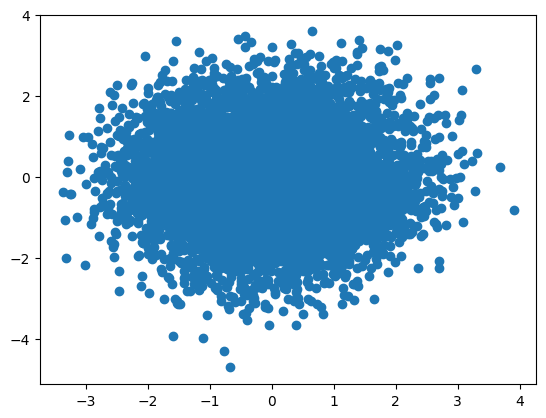

In [121]:
lb = lb_dec = y_test_cat
h = encoder.predict([x_test, lb], batch_size=batch_size)
plt.scatter(h[:, 0], h[:, 1])

In [1]:
prompt=5

num=1
n=4
total=2*n+1
input_lbl = np.zeros((1, num_classes))
input_lbl[0, prompt] = 1
h = np.zeros((1, hidden_dim))

plt.figure(figsize=(total, total))
for i in range(-n, n+1):
    for j in range(-n, n+1):
        ax = plt.subplot(total, total, num)
        num += 1
        h[0, :] = [1*i/n, 1*j/n]
        img = decoder.predict([h, input_lbl])
        plt.imshow(img.squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

NameError: name 'np' is not defined

In [111]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4548689261966497866
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2357670708
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8332774607042053429
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2024-04-26 00:41:58.344752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 00:41:58.344864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 00:41:58.344892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 00:41:58.345142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 00:41:58.345156: I tensorflow/core/co